<a href="https://colab.research.google.com/github/megnaanand/atlantic-hurricane-trajectory-prediction/blob/main/final_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Correlation Coefficient - Looking at how the features correlate within playlists

This section delves into the statistical examination of 12 distinct musical features across 1000 playlists. The focus here is on calculating the average correlation coefficients for each feature, offering a comprehensive view of which features are most similar among songs within a playlist that go well together, and which are most different. The lower the correlation coefficient value, the less variation there is of that feature amongst songs in a given playlist.



In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/content/sample_data/merged_playlist_without_duplicates_0_999.csv')

# List of features to analyze
features = ['POPULARITY', 'DANCEABILITY', 'ACOUSTICNESS', 'ENERGY', 'INSTRUMENTALNESS',
            'VALENCE', 'TEMPO', 'LIVENESS', 'LOUDNESS', 'MODE', 'KEY', 'SPEECHINESS']

df['INSTRUMENTALNESS'] += 1
df['INSTRUMENTALNESS'] = np.log(df['INSTRUMENTALNESS'])

# Calculate the mean for each playlist and feature
playlist_means = df.groupby('PLAYLIST_id')[features].mean()

# Calculate the standard deviation for each playlist and feature
playlist_std_devs = df.groupby('PLAYLIST_id')[features].std()

# Calculate the Coefficient of Variation for each playlist and feature
playlist_cv = playlist_std_devs / playlist_means

# Calculate the mean Coefficient of Variation for each feature across all playlists
mean_cv_across_playlists = playlist_cv.mean()

print("Coefficient of Variation for Each Feature Across All Playlists:")
print(mean_cv_across_playlists.abs().sort_values(ascending=True))

Coefficient of Variation for Each Feature Across All Playlists:
DANCEABILITY        0.225554
TEMPO               0.231488
ENERGY              0.289662
LOUDNESS            0.361610
VALENCE             0.444259
KEY                 0.709852
MODE                0.734123
LIVENESS            0.748750
SPEECHINESS         0.764847
POPULARITY          0.888399
ACOUSTICNESS        1.103000
INSTRUMENTALNESS    3.869145
dtype: float64


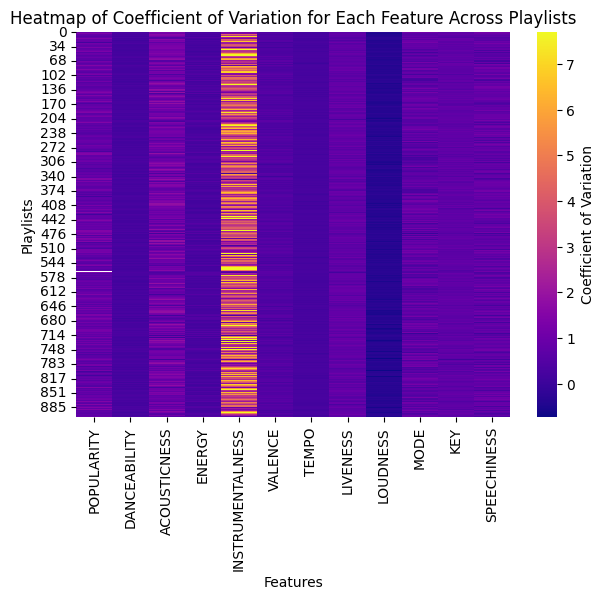

In [4]:
# Cap the values at the 95th percentile for each feature
cap_values = playlist_cv.quantile(0.95)
capped_playlist_cv = playlist_cv.clip(upper=cap_values, axis=1)

plt.figure(figsize=(7, 5))
sns.heatmap(capped_playlist_cv, cmap='plasma', cbar_kws={'label': 'Coefficient of Variation'})
plt.title('Heatmap of Coefficient of Variation for Each Feature Across Playlists')
plt.xlabel('Features')
plt.ylabel('Playlists')
plt.show()


This is a visual representation of the coefficients found above. As we can see, loudness, danceability, energy, and tempo tend to be the most similar amongst songs in a playlist, and instrumentalness tends to vary the most.

In [5]:
happy_df_1 = df[df['PLAYLIST_name'] == 'happy']
happy_df_2 = df[df['PLAYLIST_name'] == 'Happy Happy Happy']
sad_df_1 = df[df['PLAYLIST_name'] == 'tears.']
sad_df_2 = df[df['PLAYLIST_name'] == 'sad']
hype_df_1 = df[df['PLAYLIST_name'] == 'hype']
hype_df_2 = df[df['PLAYLIST_name'] == 'Hype']

def analyze_playlists(df_1, df_2, mood):
  # Concatenate the two 'happy' playlist DataFrames, assuming there's a unique song identifier column named 'SONG_ID'
  total_df = pd.concat([df_1, df_2])
  # Drop duplicates based on the song identifier
  df_unique = total_df.drop_duplicates(subset='TRACK_uri')
  print(df_unique.shape)
  # Calculate the mean for each feature for the unique happy songs
  mean_df = df_unique[features].mean()
  # Calculate the standard deviation for each feature for the unique happy songs
  cv_df = df_unique[features].std()/mean_df
  print(mood + ' Means')
  print(mean_df)
  print('\n')
  print(mood + ' CVs')
  print(cv_df)
  print('\n')
  return mean_df, cv_df

mean_happy, cv_happy = analyze_playlists(happy_df_1, happy_df_2, 'Happy')
mean_sad, cv_sad = analyze_playlists(sad_df_1, sad_df_2, 'Sad')
mean_hype, cv_hype = analyze_playlists(hype_df_1, hype_df_2, 'Hype')

(106, 22)
Happy Means
POPULARITY           33.254717
DANCEABILITY          0.579340
ACOUSTICNESS          0.299475
ENERGY                0.620811
INSTRUMENTALNESS      0.020036
VALENCE               0.460890
TEMPO               117.617462
LIVENESS              0.146191
LOUDNESS             -7.243811
MODE                  0.877358
KEY                   4.245283
SPEECHINESS           0.053815
dtype: float64


Happy CVs
POPULARITY          1.000065
DANCEABILITY        0.232285
ACOUSTICNESS        1.054974
ENERGY              0.371413
INSTRUMENTALNESS    3.553818
VALENCE             0.527538
TEMPO               0.229782
LIVENESS            0.561022
LOUDNESS           -0.404928
MODE                0.375654
KEY                 0.863078
SPEECHINESS         0.948769
dtype: float64


(96, 22)
Sad Means
POPULARITY           28.437500
DANCEABILITY          0.486284
ACOUSTICNESS          0.526137
ENERGY                0.456509
INSTRUMENTALNESS      0.143050
VALENCE               0.294464
TEMPO    

### Looking at how features vary across moods
This section aims to look at how the different features vary across happy playlists, sad playlists, and hype playlists.

In [6]:
def plot_distribution_bar_graphs(df_dict, features):
    # Number of features
    num_features = len(features)

    # Number of moods
    num_moods = len(df_dict)

    # Create a figure with subplots - one row for each feature, and one column for each mood
    fig, axes = plt.subplots(num_features, num_moods, figsize=(5 * num_moods, 4 * num_features))

    # Iterate through each feature and plot the distribution for each mood
    for i, feature in enumerate(features):
        for j, (mood, df) in enumerate(df_dict.items()):
            ax = axes[i, j] if num_features > 1 else axes[j]
            # Plot a histogram for the current mood and feature
            df[feature].plot(kind='hist', ax=ax, alpha=0.7, label=mood, bins=15)
            ax.set_title(f'{feature} - {mood}')
            ax.set_xlabel('Value')
            ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [9]:
def plot_boxplots_for_moods(df_dict, features):
    num_features = len(features)
    num_moods = len(df_dict)

    colors = ['skyblue', 'lightcoral', 'plum', 'lightpink']

    fig, axes = plt.subplots(num_features, 1, figsize=(10, 5 * num_features))

    for i, feature in enumerate(features):
        ax = axes[i] if num_features > 1 else axes
        data = [df[feature] for df in df_dict.values()]

        bp = ax.boxplot(data, patch_artist=True, labels=df_dict.keys())

        for patch, color in zip(bp['boxes'], colors[:num_moods]):
            patch.set_facecolor(color)

        ax.set_title(feature)
        ax.set_ylabel('Value')

    plt.tight_layout()
    plt.show()

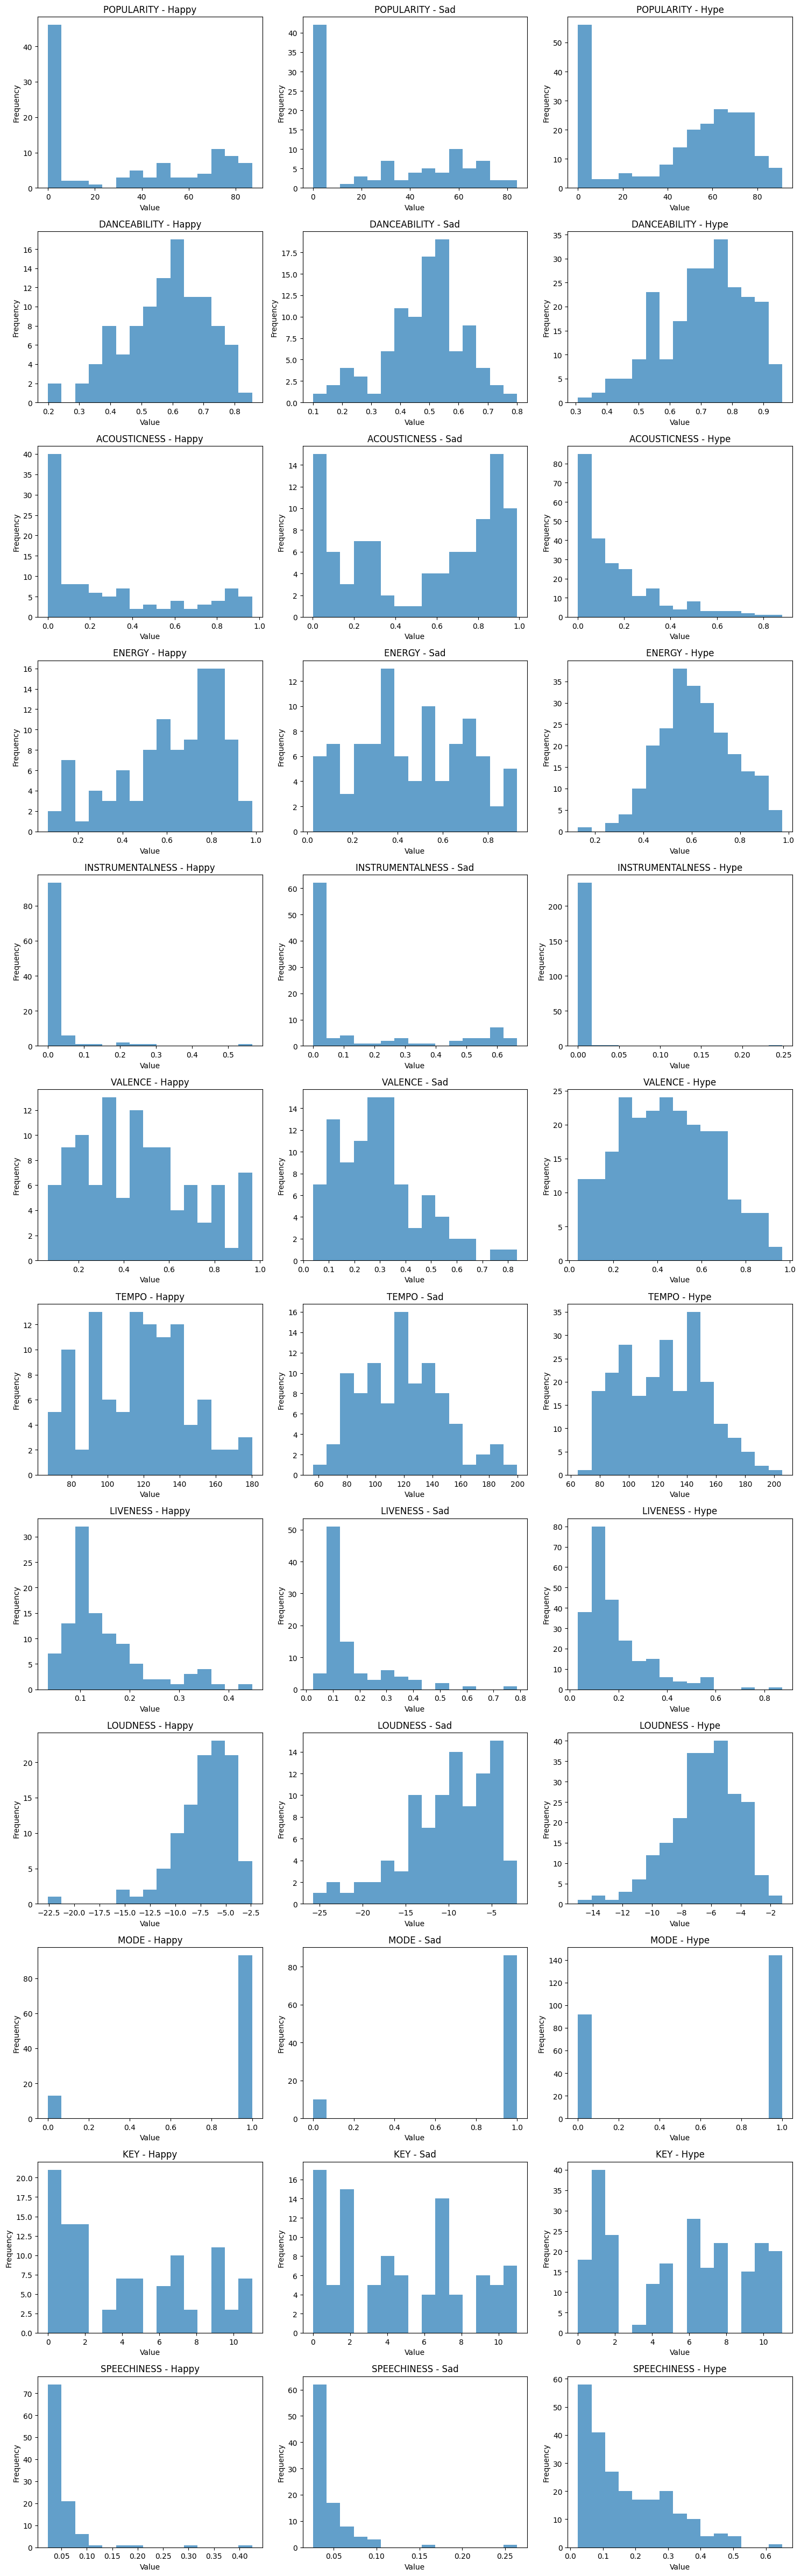

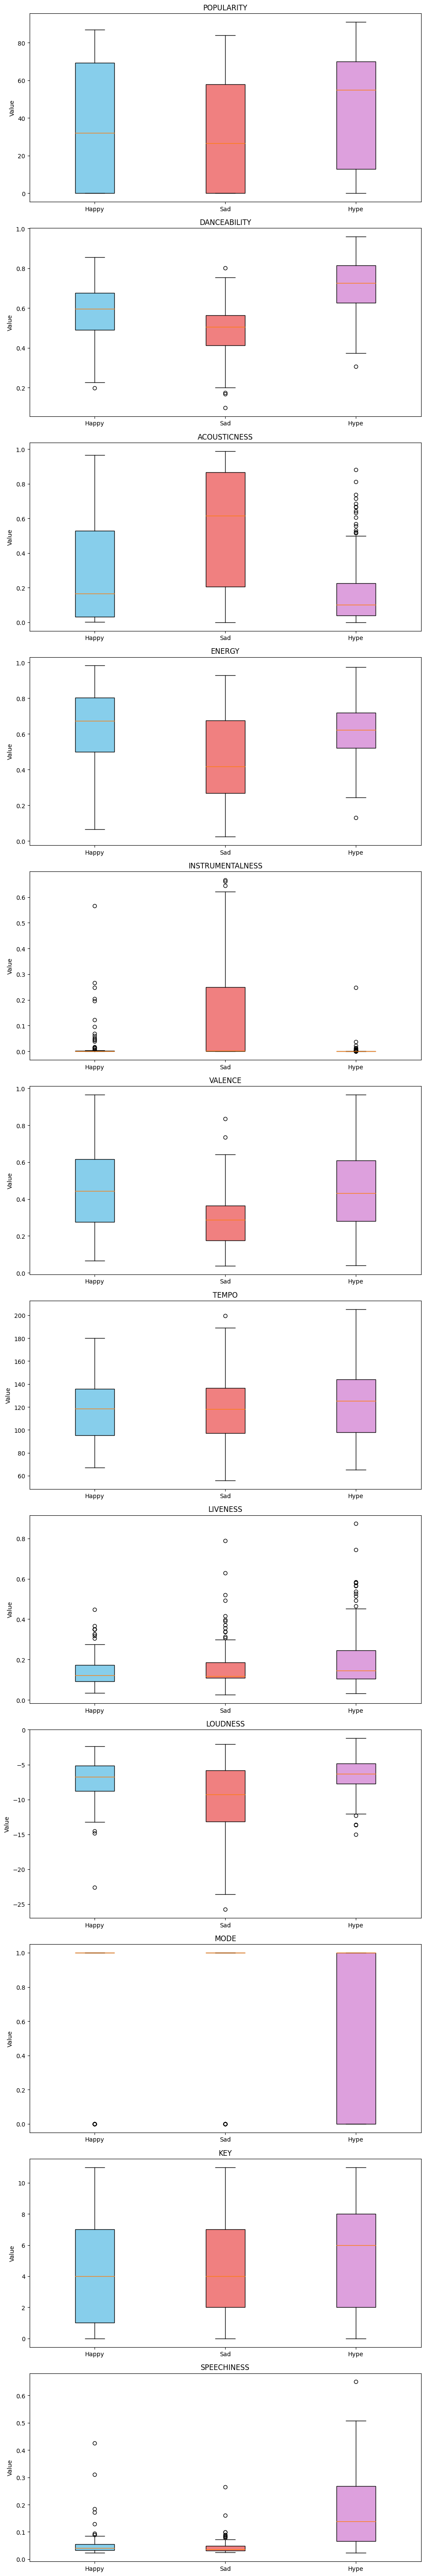

In [10]:
features = ['POPULARITY', 'DANCEABILITY', 'ACOUSTICNESS', 'ENERGY', 'INSTRUMENTALNESS',
            'VALENCE', 'TEMPO', 'LIVENESS', 'LOUDNESS', 'MODE', 'KEY', 'SPEECHINESS']

mood_dfs = {'Happy': pd.concat([happy_df_1, happy_df_2]).drop_duplicates(subset='TRACK_uri'),
            'Sad': pd.concat([sad_df_1, sad_df_2]).drop_duplicates(subset='TRACK_uri'),
            'Hype': pd.concat([hype_df_1, hype_df_2]).drop_duplicates(subset='TRACK_uri')}

plot_distribution_bar_graphs(mood_dfs, features)
plot_boxplots_for_moods(mood_dfs, features)

This section visually depicts how the features vary across moods. The most notable differences seem to be that hype playlists have the highest values for speechiness, danceability, and popularity. Happy and hype playlists tend to have higher loudness and energy values than sad playlists. Sad playlists tend to have much higher acousticness values compared to happy and hype playlists.